In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
times = pd.read_csv('data/seattle_bus_times_NC.csv')

def mae_loss(theta, y_vals):
    return np.mean(np.abs(y_vals - theta))

def try_thetas(thetas, y_vals, xlims, loss_fn=mae_loss, figsize=(5, 3),
               rug_height=0.1, cols=3):
    if not isinstance(y_vals, np.ndarray):
        y_vals = np.array(y_vals)
    rows = int(np.ceil(len(thetas) / cols))
    plt.figure(figsize=figsize)
    for i, theta in enumerate(thetas):
        ax = plt.subplot(rows, cols, i + 1)
        sns.rugplot(y_vals, height=rug_height, ax=ax)
        plt.axvline(theta, linestyle='--',
                    label=rf'$ \theta = {theta} $')
        plt.title(f'Loss = {loss_fn(theta, y_vals):.2f}')
        plt.xlim(*xlims)
        plt.yticks([])
        plt.legend()
    plt.tight_layout()

# Loss Functions

We're modeling how late the northbound C bus is with a constant called
$\theta$, and we want to use the dataset of arrival times to figure
out a good value for $\theta$.
To find $\theta$, we'll use a *loss function*---a function that measures
how far away our model is from the actual data.

A loss function is a mathematical function that takes in $\theta$ and a
data value $y$. It outputs a single number, the *loss*, that
measures how far away $\theta$ is from $y$. We write the loss function
as ${\cal l}(\theta, y)$.

By convention, the loss function outputs lower values for better values of
$\theta$ and larger values for worse $\theta$. To fit a model to our data, we
select the particular $\theta$ that produces a lower average loss than all
other choices; in other words we find the $\theta$ that *minimizes the average
loss* for our data, $y_1, \ldots, y_n$. We write the average loss as
$L(\theta, y_1, y_2, \ldots, y_n)$, where


$$
\begin{aligned}
L(\theta, y_1, y_2, \ldots, y_n)
&= \text{mean}\left\{ {\cal l}(\theta, y_1),
      {\cal l}(\theta, y_2), \ldots,
      {\cal l}(\theta, y_n) \right\} \\
&= \frac{1}{n} \sum_{i = 1}^{n} {\cal l}(\theta, y_i)\\
\end{aligned}
$$


As a shorthand, we often define the vector
$ \textbf{y} = [ y_1, y_2, \ldots, y_n ] $.
Then, we can write the average loss as:

$$
L(\theta, \textbf{y})
= \frac{1}{n} \sum_{i = 1}^{n}l(\theta, {y_i})\\
$$


:::{note}

Notice that ${\cal l}(\theta, y)$ tells us our model's loss on a single data
point while $ L(\theta, \textbf{y}) $ tells us our model's average
loss for all of our data points. The capital $L$ helps us remember that the
average loss combines multiple smaller $\cal l$ values.

:::

Once we define a loss function, we can find the value of $\theta$ that produces
the smallest average loss. We call this $\hat{\theta}$, the minimizing value of
$L(\theta, {\bf y})$. In other words, of all the possible $\theta$ values,
$\hat{\theta}$ is the one that produces the smallest average loss on our data.
We call this *fitting a model* to our data, since it finds the best model for a
given loss function.

Next, we'll look at two specific loss functions: absolute error and square
error. Our goal is to fit our model and find $\hat{\theta}$ for both of these
loss functions.

## Mean Absolute Error

We start with the *absolute error* loss function. Here's the idea behind
absolute loss: 

1. For some value of $\theta$ and data value $y$, 
1. Find the error: $y - \theta$, and
1. Take the absolute value of the error: $|y - \theta|$. 

So, our loss function is ${\cal l}(\theta, y) = | y - \theta |$.

Taking the absolute value of the error is a simple way to convert negative
errors into positive ones. For instance, if our point,
$y=4$, is equally far away from $\theta = 2$ and $\theta = 6$, the errors are
equally "bad".

The average loss for this loss function is called the mean absolute error, or
MAE for short. The MAE is the average of each of the individual absolute
errors:

$$
L(\theta, {\bf y})
= \frac{1}{n} \sum_{i = 1}^{n} |y_i - \theta|\\
$$

Notice that the name MAE, tells you how to compute it--take the mean of the
absolute errors.

We can write a simple Python function to compute this loss:

In [3]:
def mae_loss(theta, y_vals):
    return np.mean(np.abs(y_vals - theta))

Let's see how this loss function behaves when we have just five points $[ -1, 0, 2, 5, 10]$. We can try different values of $\theta$ and see what the loss function outputs for each value.

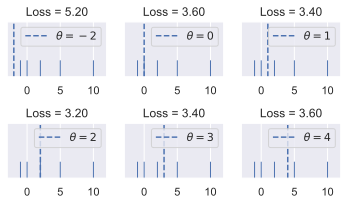

In [4]:
try_thetas(thetas=[-2, 0, 1, 2, 3, 4],
           y_vals=[-1, 0, 2, 5, 10],
           rug_height=0.3,
           xlims=(-3, 12))

We suggest verifying some of these loss values by hand to check that you
understand how the MAE is computed.

Of the values of $\theta$ that we tried, we found that $ \theta = 2 $ has the
lowest mean absolute error. For this simple example, this value is the median
of the data values. This isn't a coincidence---let's now see what the loss
function outputs on the original dataset of bus times. We'll find the MAE when
we set $\theta$ to the mode, median, and mean of the arrival times.

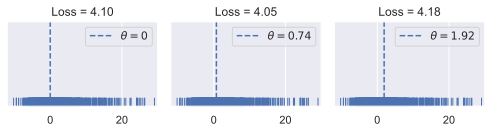

In [5]:
try_thetas(thetas=[0, 0.74, 1.92],
           y_vals=times['minutes_late'],
           xlims=(-12, 30), figsize=(7, 2))

We see again that the median (middle plot) gives a smaller loss than the mode
and mean (left and right plots).
In fact, we can prove that for absolute
loss, the minimizing
$\hat{\theta} = \text{median} \{ y_1, y_2, \ldots, y_n \}$.
(The actual proof is left as an exercise.)

So far, we have found the best value of $ \theta $ by simply trying out a few 
values and then picking the one with the smallest loss. To get a better
sense of the MAE as a function of $\theta$, we can try many more values of
$\theta$ to see a complete curve that shows how $L(\theta, {\bf{y}})$ changes
as $\theta$ changes. We draw the curve for the example from above with the five
data values, $[ -1, 0, 2, 5, 10]$.

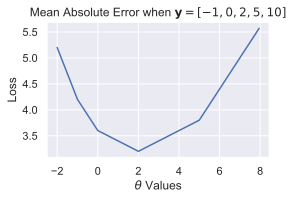

In [6]:
thetas = np.arange(-2, 8, 0.05)
y_vals=np.array([-1, 0, 2, 5, 10])
losses = [mae_loss(theta, y_vals) for theta in thetas]

plt.figure(figsize=(4, 2.5))
plt.plot(thetas, losses)
plt.title(r'Mean Absolute Error when $\bf{y}$$ = [-1, 0, 2, 5, 10] $')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss');

The plot above shows that in fact, $ \theta = 2$ is the best choice for the
small dataset of five values.  Notice the shape of curve. It is piecewise
linear, where the line segments connect at the location of the data values (-1,
0, 2, and 5). This is a property of the absolute value function. With a lot of
data, the flat pieces are less obvious. Our bus data have over 1400 points and 
its MAE curve appears below.

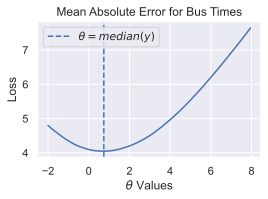

In [7]:
thetas = np.arange(-2, 8, 0.05)
y_vals=times['minutes_late']
losses = [mae_loss(theta, y_vals) for theta in thetas]

plt.figure(figsize=(4, 2.5))
plt.plot(thetas, losses)
plt.axvline(np.median(y_vals), linestyle='--',
                    label=rf'$\theta = median(y)$')
plt.title(r'Mean Absolute Error for Bus Times')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss')
plt.legend();

We can use this plot to help confirm that the median of the data is the
minimizing value, in other words $\hat \theta = 0.74$.

Next, let's look at another loss function, the squared error.

## Mean Squared Error

We have used a constant model for our data and found that with mean absolute error, the minimizer is the median. Now, we will keep our model the same but switch to a different loss function: squared error. Instead of taking the absolute difference between our data value $y$ and the constant $\theta$, we square the error:

1. For some value of $\theta$ and data value $y$, 
1. Find the error: $y - \theta$ and
1. Take the squared value of the error: $(y - \theta)^2$. 

This gives the loss function ${\cal l}(\theta, y) = (y - \theta)^2$.


As before, we want to use all of our data to find the best $\theta$ so we compute the mean squared error, or MSE for short:

$$
L(\theta, {\bf y}) = L(\theta, y_1, y_2, \ldots, y_n)
= \frac{1}{n} \sum_{i = 1}^{n} (y_i - \theta)^2
$$

We can write a simple Python function to compute the MSE:

In [8]:
def mse_loss(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

Let's again try the mean, median, and mode as potential minimizers of the MSE.

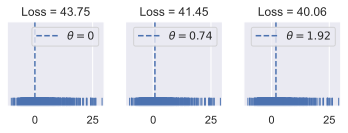

In [10]:
try_thetas(thetas=[0, 0.74, 1.92],
           y_vals=times['minutes_late'],
           xlims=(-12, 30), loss_fn=mse_loss, figsize=(5, 2))

Now, when we fit the constant model using MSE loss, we find that the mean
(right plot) has a smaller loss than the mode and the median (left and middle
plot).

Let's plot the MSE curve for different values of $\theta$ on our data.
We can see that the minimizing value $ \hat{\theta} $ is close to 2.

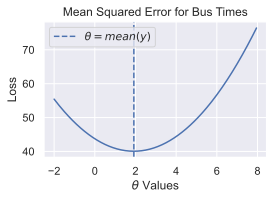

In [11]:
thetas = np.arange(-2, 8, 0.05)
y_vals=times['minutes_late']
losses = [mse_loss(theta, y_vals) for theta in thetas]

plt.figure(figsize=(4, 2.5))
plt.plot(thetas, losses)
plt.axvline(np.mean(y_vals), linestyle='--',
                    label=rf'$\theta = mean(y)$')
plt.title(r'Mean Squared Error for Bus Times')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss')
plt.legend();

One feature of this curve that is quite noticable is how rapidly large the MSE grows compared to  the MAE. This growth has to do with the nature of squaring errors; it places a much higher loss on data values further away. If $\theta = 10$ and $y = 110$, the squared loss is $(10 - 110)^2 = 10000$ whereas the absolute loss is $|10 - 110| = 100$. For this reason, MSE is more sensitive to outliers than MAE.

When we use MSE loss, we saw that 
$ \hat{\theta} = \text{mean} (\textbf{y})$. 
Again, this no mere coincidence; the mean of the data *always* produces the
$ \theta $ that minimizes the MSE.
We'll show how this comes out using calculus. To minimize average loss, we 
take the derivative of the average loss with respect to $ \theta $:


$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\frac{\partial}{\partial \theta} L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n} -2(y_i - \theta) \\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - \theta) \\
\end{aligned}
$$


Then, we set the derivative to 0 and solve for $\hat \theta$: 

$$
\begin{aligned}
0 &= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - {\hat \theta}) \\
{\hat \theta} &= \frac{1}{n} \sum_{i = 1}^{n} y_i \\
  &= {\bar y} & \text{(a shorthand for the mean)}
\end{aligned}
$$


Lo and behold, we see that there is a single value of $\theta$ that gives the
smallest possible MSE no matter what the dataset is. For the mean squared
error, we have shown that ${\hat \theta}= {\bar y}$ [^2nd].


[^2nd]: To be thorough, we would use a second derivative to confirm that
$\bar{y}$ is a minimizer.

## Choosing Loss Functions

Now that we've worked with loss functions, we can return to our original
question: why would we choose the median, mean, or mode over the others? Since
the median, mean, and mode minimize different loss functions [^mode],
we can equivalently ask: what is the most appropriate loss function for our
problem? To answer this question, we look at the context of our problem.

[^mode]: The mode minimizes a loss function called 0-1 loss. Although we
    haven't covered this specific loss, the procedure is identical: pick
    the loss function, then find $\hat{\theta}$ that minimizes the loss.


Compared to the MAE, the MSE gives especially large loss values when the bus is
much later (or earlier) than we expect. So, a bus rider who despises unexpected
wait times would guess that the bus will be 1.92 minutes late (the mean)
instead of 0.74 minutes late (the median).

Using either the MAE or MSE is fine if we're using our model to estimate
how late the bus will be. What if we wanted to create a model to tell a bus 
rider when to arrive at the bus stop? If we used MAE or MSE for this
purpose, we would say that arriving 5 minutes before the bus arrives is just as
good as arriving 5 minutes after the bus arrives.
But missing a bus can be much
more inconvenient than getting there a few minutes early.
To model this, we'd choose an *asymmetric loss function* that penalizes missing
a bus more than arriving early. This kind of loss function would probably 
result in a model that tells the bus rider to get to the
stop a few minutes early.

In essence, context matters when choosing a
loss function. By thinking carefully about what we will use our model to do, we
can pick a loss function that helps us make good decisions using data.